In [80]:
import stock_helper
import pandas as pd
from datetime import datetime
import numpy as np

dataset = stock_helper.fetch_stock_data('GOOG', '30y')

In [155]:
df = stock_helper.generate_indicators(dataset, 
                                      timeperiod=2, 
                                      generate_target=True, 
                                      reset_index=True)

# Convert date to the n-th day from 1970-01-01
df['date'] = df['date'].apply(lambda date64: (date64 - np.datetime64('1970-01-01T00:00:00')) / np.timedelta64(1, 'D'))

In [156]:
df.head()

,date,high,low,open,close,volume,RSI,MOM,slowk,slowd,macd,macdsignal,macdhist,ADX,SMA,upper_bb,middel_bb,lower_bb,next_2day_trend
0,12649.0,51.835709,47.800831,49.813290,49.982655,44871361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,12650.0,54.336334,50.062355,50.316402,53.952770,22942874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,12653.0,56.528118,54.321388,55.168217,54.495735,18342897,100.000000,4.513081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,12654.0,55.591629,51.591621,55.412300,52.239197,15319808,50.000021,-1.713573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,12655.0,53.798351,51.746044,52.284027,52.802086,9232276,59.982343,-1.693649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [157]:
df = df.drop(columns = ["RSI", "MOM", "slowk", "slowd", "macd", "macdsignal", "macdhist", "ADX", "SMA", "upper_bb", "middel_bb", "lower_bb"])

df.head()

,date,high,low,open,close,volume,next_2day_trend
0,12649.0,51.835709,47.800831,49.813290,49.982655,44871361,1
1,12650.0,54.336334,50.062355,50.316402,53.952770,22942874,0
2,12653.0,56.528118,54.321388,55.168217,54.495735,18342897,0
3,12654.0,55.591629,51.591621,55.412300,52.239197,15319808,1
4,12655.0,53.798351,51.746044,52.284027,52.802086,9232276,1


In [158]:
df = df.drop(columns = ["date"])

df.head()

,high,low,open,close,volume,next_2day_trend
0,51.835709,47.800831,49.813290,49.982655,44871361,1
1,54.336334,50.062355,50.316402,53.952770,22942874,0
2,56.528118,54.321388,55.168217,54.495735,18342897,0
3,55.591629,51.591621,55.412300,52.239197,15319808,1
4,53.798351,51.746044,52.284027,52.802086,9232276,1


In [159]:
df = df.dropna()


train_size = int(len(df) * 0.8)
train = df.iloc[:train_size, :]
test = df.iloc[train_size:, :]

target_name = df.columns[-1]
train_X = train.drop(target_name, axis = 1)
train_y = train[target_name]

test_X = test.drop(target_name, axis = 1)
test_y = test[target_name]

In [160]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=2)
clf.fit(train_X, train_y)
prediction = clf.predict(test_X)

from sklearn.metrics import accuracy_score
accuracy_score(test_y, prediction)

0.5629453681710214

In [161]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=5)
clf.fit(train_X, train_y)
prediction = clf.predict(test_X)

accuracy_score(test_y, prediction)

0.4655581947743468

In [162]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=4)
clf.fit(train_X, train_y)
prediction = clf.predict(test_X)

from sklearn.metrics import accuracy_score
accuracy_score(test_y, prediction)

0.5522565320665083

In [163]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=8)
clf.fit(train_X, train_y)
prediction = clf.predict(test_X)

accuracy_score(test_y, prediction)

0.4655581947743468

In [164]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
x_train_counts = count_vect.fit_transform(train_X).toarray()
x_test_counts = count_vect.transform(test_X).toarray()

In [165]:
x_train_counts.shape

(5, 5)

In [166]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression()
clf.fit(train_X, train_y)

hyp = clf.predict(test_X)
accuracy_score(test_y, hyp)

0.5629453681710214

In [167]:
train_X

,high,low,open,close,volume
0,51.835709,47.800831,49.813290,49.982655,44871361
1,54.336334,50.062355,50.316402,53.952770,22942874
2,56.528118,54.321388,55.168217,54.495735,18342897
3,55.591629,51.591621,55.412300,52.239197,15319808
4,53.798351,51.746044,52.284027,52.802086,9232276
...,...,...,...,...,...
3363,1058.369995,1048.050049,1057.390015,1049.369995,1271900
3364,1054.750000,1044.770020,1051.599976,1048.140015,837100
3365,1049.699951,1044.900024,1046.719971,1046.400024,887500
3366,1066.939941,1045.229980,1048.339966,1065.000000,1237600


In [168]:
train_y

0       1
1       0
2       0
3       1
4       1
       ..
3363    0
3364    1
3365    1
3366    1
3367    1
Name: next_2day_trend, Length: 3368, dtype: int64

In [169]:
train_x_2 = train_X.copy()

train_y_2 = train_y.copy()

test_x_2 = test_X.copy()

test_y_2 = test_y.copy()

In [170]:
df2 = df.copy()



In [171]:
# Helper Functions
# In order to print all performance metrics relevant to a regression task (such as MAE and R-square), we will be defining the regression_results function.

import sklearn.metrics as metrics
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [172]:
# use the difference between today and today - 1, today - 1 and today - 2, ... today - 4 and today - 5

df3 = pd.DataFrame()

for columnName in df2.columns:
    if columnName != "volume" and columnName != "next_2day_trend":
        column = df2[[columnName]]

        df3.loc[:,'shift1' + columnName] = df2.loc[:,columnName].shift() - df2.loc[:,columnName]

        df3.loc[:,'shift2' + columnName] = df2.loc[:,columnName].shift().shift() - df2.loc[:,columnName].shift()

        df3.loc[:,'shift3' + columnName] = df2.loc[:,columnName].shift().shift().shift() - df2.loc[:,columnName].shift().shift()

        df3.loc[:,'shift4' + columnName] = df2.loc[:,columnName].shift().shift().shift().shift() - df2.loc[:,columnName].shift().shift().shift()

        df3.loc[:,'shift5' + columnName] = df2.loc[:,columnName].shift().shift().shift().shift().shift() - df2.loc[:,columnName].shift().shift().shift().shift()


#add volumn and and next_5day_trend, then drop na
# df3["date"] = df2["date"]
df3["volume"] = df2["volume"]
df3["next_2day_trend"] = df2["next_2day_trend"]

df3 = df3.dropna()



In [173]:
df3.head()

,shift1high,shift2high,shift3high,shift4high,shift5high,shift1low,shift2low,shift3low,shift4low,shift5low,...,shift3open,shift4open,shift5open,shift1close,shift2close,shift3close,shift4close,shift5close,volume,next_2day_trend
5,0.024906,1.793278,0.936489,-2.191784,-2.500626,-0.388542,-0.154423,2.729767,-4.259033,-2.261524,...,-0.244083,-4.851814,-0.503113,-0.951431,-0.562889,2.256538,-0.542965,-3.970116,7128620,0
6,-0.333748,0.024906,1.793278,0.936489,-2.191784,-0.513077,-0.388542,-0.154423,2.729767,-4.259033,...,3.128273,-0.244083,-4.851814,0.876713,-0.951431,-0.562889,2.256538,-0.542965,6241307,0
7,1.559155,-0.333748,0.024906,1.793278,0.936489,1.833130,-0.513077,-0.388542,-0.154423,2.729767,...,0.004982,3.128273,-0.244083,2.062271,0.876713,-0.951431,-0.562889,2.256538,5221498,0
8,0.886677,1.559155,-0.333748,0.024906,1.793278,-0.074722,1.833130,-0.513077,-0.388542,-0.154423,...,-1.569118,0.004982,3.128273,-0.179329,2.062271,0.876713,-0.951431,-0.562889,4941252,0
9,0.368618,0.886677,1.559155,-0.333748,0.024906,1.240353,-0.074722,1.833130,-0.513077,-0.388542,...,1.404736,-1.569118,0.004982,1.056042,-0.179329,2.062271,0.876713,-0.951431,9181687,0


In [174]:
X_train = df3.drop(['next_5day_trend'], axis = 1)
y_train = df3["next_5day_trend"]
X_test = data_consumption['2017'].drop(['Consumption'], axis = 1)
y_test = data_consumption.loc['2017', 'Consumption']

KeyError: "['next_5day_trend'] not found in axis"

In [175]:
train_size = int(len(df3) * 0.8)
train = df3.iloc[:train_size, :]
test = df3.iloc[train_size:, :]

target_name = df.columns[-1]
train_X = train.drop(target_name, axis = 1)
train_y = train[target_name]

test_X = test.drop(target_name, axis = 1)
test_y = test[target_name]

In [146]:
train_X.head()

,shift1high,shift2high,shift3high,shift4high,shift5high,shift1low,shift2low,shift3low,shift4low,shift5low,...,shift1close,shift2close,shift3close,shift4close,shift5close,shift1volume,shift2volume,shift3volume,shift4volume,shift5volume
38,-2.958908,0.622665,0.408470,0.099625,-0.712326,-3.327522,0.224159,1.579079,-0.234123,-0.273972,...,-1.743462,-1.066002,1.230385,0.557907,-0.881691,-8139194.0,-1199078.0,600242.0,3060027.0,-737153.0
39,0.582817,-2.958908,0.622665,0.408470,0.099625,0.757156,-3.327522,0.224159,1.579079,-0.234123,...,-0.547951,-1.743462,-1.066002,1.230385,0.557907,9368384.0,-8139194.0,-1199078.0,600242.0,3060027.0
40,-1.554176,0.582817,-2.958908,0.622665,0.408470,-1.688667,0.757156,-3.327522,0.224159,1.579079,...,-1.051056,-0.547951,-1.743462,-1.066002,1.230385,-2765728.0,9368384.0,-8139194.0,-1199078.0,600242.0
41,-1.843094,-1.554176,0.582817,-2.958908,0.622665,0.368614,-1.688667,0.757156,-3.327522,0.224159,...,-2.515572,-1.051056,-0.547951,-1.743462,-1.066002,-845557.0,-2765728.0,9368384.0,-8139194.0,-1199078.0
42,-1.594025,-1.843094,-1.554176,0.582817,-2.958908,-3.058533,0.368614,-1.688667,0.757156,-3.327522,...,0.607719,-2.515572,-1.051056,-0.547951,-1.743462,-4092884.0,-845557.0,-2765728.0,9368384.0,-8139194.0


LR: -0.034200 (0.006166)
RFR: -0.992980 (0.066256)
DT: -0.952300 (0.078352)


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

NN: -24326029.292396 (30348777.709971)
KNN: -0.167757 (0.018768)
RF: -0.133690 (0.019762)
SVR: -0.002093 (0.001217)


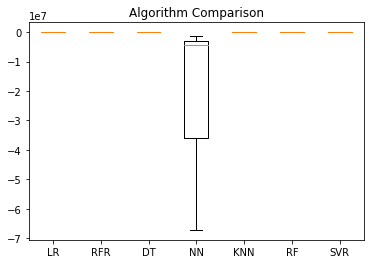

In [147]:
# //TODO: use cross-validation!!!

import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier

# Spot Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('RFR', RandomForestClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('NN', MLPRegressor(solver = 'lbfgs', max_iter = 500)))  #neural network
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=3)
    
    cv_results = cross_val_score(model, train_X, train_y, cv=tscv, scoring='r2')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [148]:
# //TODO: use cross-validation!!!

In [149]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression()
clf.fit(train_X, train_y)

hyp = clf.predict(test_X)
accuracy_score(test_y, hyp)

0.4934131736526946

In [150]:
train_X.head()

,shift1high,shift2high,shift3high,shift4high,shift5high,shift1low,shift2low,shift3low,shift4low,shift5low,...,shift1close,shift2close,shift3close,shift4close,shift5close,shift1volume,shift2volume,shift3volume,shift4volume,shift5volume
38,-2.958908,0.622665,0.408470,0.099625,-0.712326,-3.327522,0.224159,1.579079,-0.234123,-0.273972,...,-1.743462,-1.066002,1.230385,0.557907,-0.881691,-8139194.0,-1199078.0,600242.0,3060027.0,-737153.0
39,0.582817,-2.958908,0.622665,0.408470,0.099625,0.757156,-3.327522,0.224159,1.579079,-0.234123,...,-0.547951,-1.743462,-1.066002,1.230385,0.557907,9368384.0,-8139194.0,-1199078.0,600242.0,3060027.0
40,-1.554176,0.582817,-2.958908,0.622665,0.408470,-1.688667,0.757156,-3.327522,0.224159,1.579079,...,-1.051056,-0.547951,-1.743462,-1.066002,1.230385,-2765728.0,9368384.0,-8139194.0,-1199078.0,600242.0
41,-1.843094,-1.554176,0.582817,-2.958908,0.622665,0.368614,-1.688667,0.757156,-3.327522,0.224159,...,-2.515572,-1.051056,-0.547951,-1.743462,-1.066002,-845557.0,-2765728.0,9368384.0,-8139194.0,-1199078.0
42,-1.594025,-1.843094,-1.554176,0.582817,-2.958908,-3.058533,0.368614,-1.688667,0.757156,-3.327522,...,0.607719,-2.515572,-1.051056,-0.547951,-1.743462,-4092884.0,-845557.0,-2765728.0,9368384.0,-8139194.0


In [152]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(train_X, train_y)
prediction = clf.predict(test_X)

from sklearn.metrics import accuracy_score
accuracy_score(test_y, prediction)

0.5293413173652695